In [2]:
import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from himalaya.backend import set_backend
from scipy.interpolate import griddata, CloughTocher2DInterpolator

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning

matplotlib.interactive(True)

# Generate scalar points

In [3]:
SUBDIVISIONS = 3

In [4]:
scalars_list = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
scalars_list = np.array(scalars_list)
for i in range(SUBDIVISIONS):
    _scalars_list = []
    for point_1 in range(len(scalars_list)):
        for point_2 in range(point_1, len(scalars_list)):
            interpolation = (scalars_list[point_1] + scalars_list[point_2]) / 2
            _scalars_list.append(interpolation)
    scalars_list = _scalars_list
scalars_list

[array([1., 0., 0.]),
 array([0.875, 0.125, 0.   ]),
 array([0.875, 0.   , 0.125]),
 array([0.75, 0.25, 0.  ]),
 array([0.75 , 0.125, 0.125]),
 array([0.75, 0.  , 0.25]),
 array([0.75, 0.25, 0.  ]),
 array([0.75 , 0.125, 0.125]),
 array([0.625, 0.375, 0.   ]),
 array([0.625, 0.25 , 0.125]),
 array([0.625, 0.125, 0.25 ]),
 array([0.75, 0.  , 0.25]),
 array([0.625, 0.25 , 0.125]),
 array([0.625, 0.125, 0.25 ]),
 array([0.625, 0.   , 0.375]),
 array([0.5, 0.5, 0. ]),
 array([0.5  , 0.375, 0.125]),
 array([0.5 , 0.25, 0.25]),
 array([0.5 , 0.25, 0.25]),
 array([0.5  , 0.125, 0.375]),
 array([0.5, 0. , 0.5]),
 array([0.75, 0.25, 0.  ]),
 array([0.75 , 0.125, 0.125]),
 array([0.625, 0.375, 0.   ]),
 array([0.625, 0.25 , 0.125]),
 array([0.625, 0.125, 0.25 ]),
 array([0.625, 0.375, 0.   ]),
 array([0.625, 0.25 , 0.125]),
 array([0.5, 0.5, 0. ]),
 array([0.5  , 0.375, 0.125]),
 array([0.5 , 0.25, 0.25]),
 array([0.625, 0.125, 0.25 ]),
 array([0.5  , 0.375, 0.125]),
 array([0.5 , 0.25, 0.25]),


# Generate data

In [34]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

In [10]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)

In [11]:
path = os.path.join("results", f"targets={n_targets}", f"samples={n_samples}", f"noise={noise_scalar}", f"cv={cv}",
                    f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying scalars")
os.makedirs(path, exist_ok=True)

In [ ]:
for scalars in scalars_list:
    print(scalars)
    csv_path = os.path.join(path, f"scores_{scalars}.csv")
    scores = pd.DataFrame()
    if os.path.exists(csv_path):
        print("skipping, already exists")
        continue
    Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar)
    print("data generated")
    x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
        Xs, Y, n_samples_train, alphas, cv)
    print("variance partitioning done")

    scores["x1_score"] = x1_score
    scores["x2_score"] = x2_score
    scores["vp_joint_score"] = joint_score
    scores["vp_shared_score"] = x1_and_x2_score
    scores["vp_x1_unique_score"] = vp_x1_unique_score
    scores["vp_x2_unique_score"] = vp_x2_unique_score
    del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
    print(scores.head())

    _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
        Xs, Y, n_samples_train, alphas, cv)
    print("residual method done")
    scores["rm_x2_to_x1_score"] = np.concatenate(
        [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
    scores["rm_x1_to_x2_score"] = np.concatenate(
        [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
    scores["rm_x1_unique_score"] = rm_x1_unique_score
    scores["rm_x2_unique_score"] = rm_x2_unique_score
    del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
    del Xs, Y
    print(scores.head())

    scores.to_csv(csv_path, index=False)

[1. 0. 0.]
skipping, already exists
[0.875 0.125 0.   ]
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.876691  0.731692        0.875762         0.732621            0.144070   
1  0.891911  0.806562        0.894166         0.804308            0.087604   
2  0.931228  0.807844        0.931231         0.807840            0.123387   
3  0.896840  0.788336        0.897885         0.787292            0.109549   
4  0.906423  0.767904        0.903934         0.770393            0.136030   

   vp_x2_unique_score  
0           -0.000929  
1            0.002254  
2            0.000004  
3            0.001045  
4           -0.002489  
residual method done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.876691  0.731692        0.875762         0.732621            0.144070   
1  0.891911  0.806562        0.894166         0.804308            0.087604   
2  0.931228  0.807844        0.931

plot points on triangle simplex

In [55]:
def plot_simplex(metric_values, interp_type='linear', fig=None, ax=None, min_total=None, max_total=None,
                 cmap=plt.get_cmap('inferno').reversed()):
    """Plots a simplex heatmap based on provided metric values.

    Args:
        metric_values: A list or numpy array of metric values corresponding to each point in the simplex.
                      The length must match the number of generated scalar points.
        interp_type: Type of interpolation to use. Can be 'linear', 'clough_tocher', or 'cubic'. Defaults to 'linear'.
    """
    if len(metric_values) != len(scalars_list):
        raise ValueError("Length of metric_values must match the number of scalar points.")

    if interp_type not in ['linear', 'clough_tocher', 'cubic']:
        raise ValueError("Invalid interpolation type. Choose 'linear', 'clough_tocher', or 'cubic'.")

    # Convert to barycentric coordinates
    barycentric_coords = scalars_list

    # Check if ax is provided or create a simplex plot
    if ax is None:
        fig, ax = plt.subplots()

    # Define simplex corners
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

    # Corner labels
    corner_labels = ['(1, 0, 0)', '(0, 1, 0)', '(0, 0, 1)']

    # Transform barycentric coordinates to Cartesian
    cartesian_coords = np.dot(barycentric_coords, corners)

    # Create grid for interpolation
    resolution = 100  # Adjust resolution as needed
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, np.sqrt(3) / 2, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Filter grid points that are outside the triangle
    triangle = matplotlib.patches.Polygon(corners, closed=True)
    mask = triangle.contains_points(grid_points)
    grid_points_filtered = grid_points[mask]

    # Interpolate values on the grid
    if interp_type == 'linear':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='linear')
    elif interp_type == 'clough_tocher':
        interp = CloughTocher2DInterpolator(cartesian_coords, metric_values)
        interp_values = interp(grid_points_filtered)
    elif interp_type == 'cubic':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='cubic')

    # Reshape interpolated values
    zz = np.full_like(xx.ravel(), np.nan)
    zz[mask] = interp_values
    zz = zz.reshape(xx.shape)

    # if total value ranges are given use those, otherwise not
    if min_total is not None and max_total is not None:
        vmin = min_total
        vmax = max_total
    else:
        vmin = np.nanmin(zz)
        vmax = np.nanmax(zz)

    # Plot the colored triangle
    im = ax.imshow(zz, extent=[0, 1, 0, np.sqrt(3) / 2], origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar
    if fig is not None:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Metric Value')

    # Draw the triangle boundaries (optional, if you want to highlight them)
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')

    # add boundary labels
    # ax.text(.25, 1/2 *  np.sqrt(3) / 2, r'$a_\mathbf{A}$', ha='right', va='bottom')
    # ax.text(1/2, 0, r'$a_\mathbf{B}$', ha='center', va='top')
    # ax.text(3/4, 1/2 *  np.sqrt(3) / 2, r'$a_\mathbf{C}$', ha='left', va='bottom')

    # Add corner labels
    ax.text(corners[0, 0], corners[0, 1], corner_labels[0],
            ha='left', va='top')
    ax.text(corners[1, 0], corners[1, 1], corner_labels[1],
            ha='right', va='top')
    ax.text(corners[2, 0], corners[2, 1], corner_labels[2],
            ha='center', va='bottom')

    # Remove x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # remove background
    ax.set_facecolor('white')

    return fig, ax, im

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7aa818418560>)

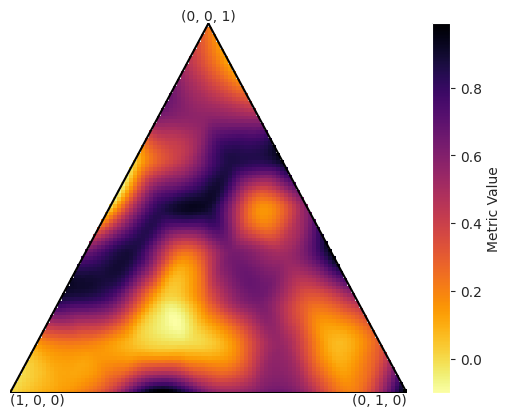

In [56]:
plot_simplex(np.random.rand(len(scalars_list)), interp_type='clough_tocher')

# plot mean error

In [63]:
vp_x1_mean_errors = []
vp_x2_mean_errors = []
rm_x1_mean_errors = []
rm_x2_mean_errors = []

vp_x1_std_errors = []
vp_x2_std_errors = []
rm_x1_std_errors = []
rm_x2_std_errors = []

for scalars in scalars_list:
    scores = pd.read_csv(os.path.join(path, f"scores_{scalars}.csv"))
    print("read scores for ", scalars)

    # calculate error
    vp_x1_error = scores["vp_x1_unique_score"] - scalars[1]
    vp_x2_error = scores["vp_x2_unique_score"] - scalars[2]
    rm_x1_error = scores["rm_x1_unique_score"] - scalars[1]
    rm_x2_error = scores["rm_x2_unique_score"] - scalars[2]

    vp_x1_mean_errors.append(vp_x1_error.mean())
    vp_x2_mean_errors.append(vp_x2_error.mean())
    rm_x1_mean_errors.append(rm_x1_error.mean())
    rm_x2_mean_errors.append(rm_x2_error.mean())
    vp_x1_std_errors.append(vp_x1_error.std())
    vp_x2_std_errors.append(vp_x2_error.std())
    rm_x1_std_errors.append(rm_x1_error.std())
    rm_x2_std_errors.append(rm_x2_error.std())

read scores for  [1. 0. 0.]
read scores for  [0.875 0.125 0.   ]
read scores for  [0.875 0.    0.125]
read scores for  [0.75 0.25 0.  ]
read scores for  [0.75  0.125 0.125]
read scores for  [0.75 0.   0.25]
read scores for  [0.75 0.25 0.  ]
read scores for  [0.75  0.125 0.125]
read scores for  [0.625 0.375 0.   ]
read scores for  [0.625 0.25  0.125]
read scores for  [0.625 0.125 0.25 ]
read scores for  [0.75 0.   0.25]
read scores for  [0.625 0.25  0.125]
read scores for  [0.625 0.125 0.25 ]
read scores for  [0.625 0.    0.375]
read scores for  [0.5 0.5 0. ]
read scores for  [0.5   0.375 0.125]
read scores for  [0.5  0.25 0.25]
read scores for  [0.5  0.25 0.25]
read scores for  [0.5   0.125 0.375]
read scores for  [0.5 0.  0.5]
read scores for  [0.75 0.25 0.  ]
read scores for  [0.75  0.125 0.125]
read scores for  [0.625 0.375 0.   ]
read scores for  [0.625 0.25  0.125]
read scores for  [0.625 0.125 0.25 ]
read scores for  [0.625 0.375 0.   ]
read scores for  [0.625 0.25  0.125]
read s

Text(0, 0.5, 'Residual Method')

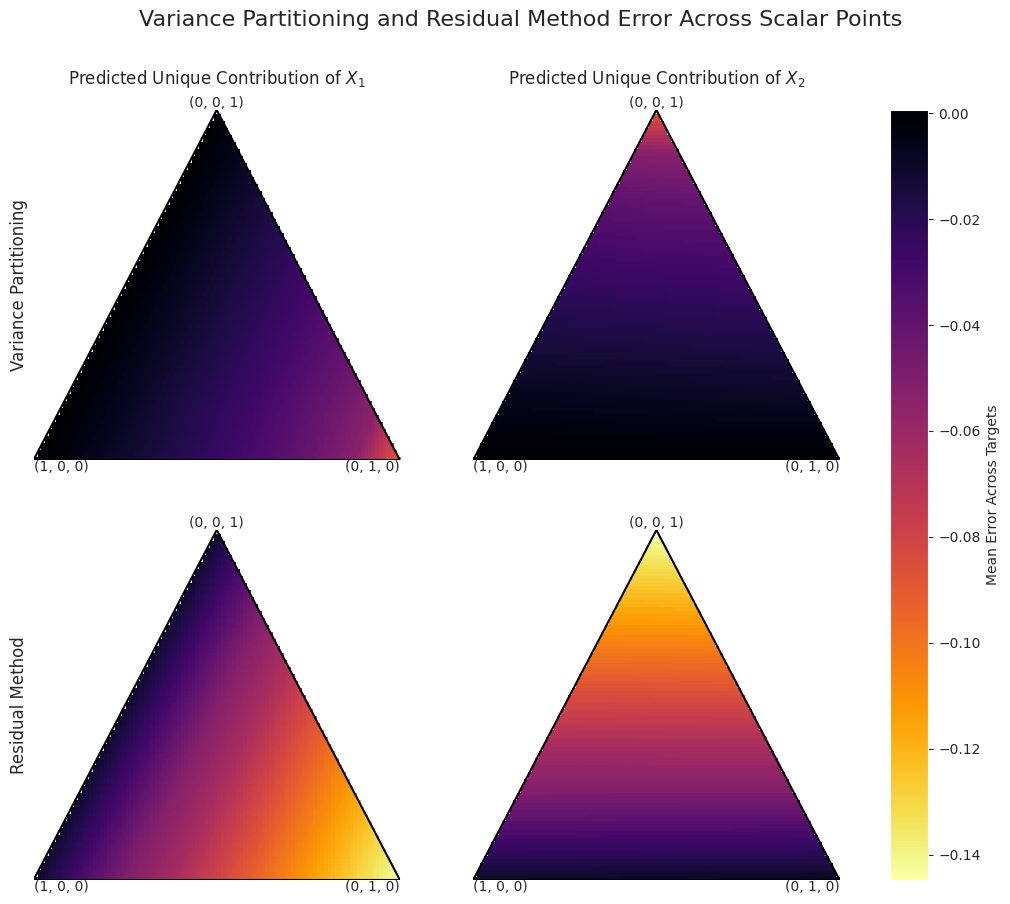

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

min_total = min(min(vp_x1_mean_errors), min(vp_x2_mean_errors), min(rm_x1_mean_errors), min(rm_x2_mean_errors))
max_total = max(max(vp_x1_mean_errors), max(vp_x2_mean_errors), max(rm_x1_mean_errors), max(rm_x2_mean_errors))

_, _, im_vp_x1 = plot_simplex(vp_x1_mean_errors, ax=axs[0, 0], min_total=min_total, max_total=max_total)
_, _, im_vp_x2 = plot_simplex(vp_x2_mean_errors, ax=axs[0, 1], min_total=min_total, max_total=max_total)
_, _, im_rm_x1 = plot_simplex(rm_x1_mean_errors, ax=axs[1, 0], min_total=min_total, max_total=max_total)
_, _, im_rm_x2 = plot_simplex(rm_x2_mean_errors, ax=axs[1, 1], min_total=min_total, max_total=max_total)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs)
cbar.set_label('Mean Error Across Targets')

fig.suptitle("Variance Partitioning and Residual Method Error Across Scalar Points", fontsize=16)

# add column wise titles
axs[0, 0].set_title(r'Predicted Unique Contribution of $X_1$', y=1.05, fontsize=12)
axs[0, 1].set_title(r'Predicted Unique Contribution of $X_2$', y=1.05, fontsize=12)

# add row titles
axs[0, 0].set_ylabel(r'Variance Partitioning', fontsize=12)
axs[1, 0].set_ylabel(r'Residual Method', fontsize=12)

Text(0, 0.5, 'Residual Method')

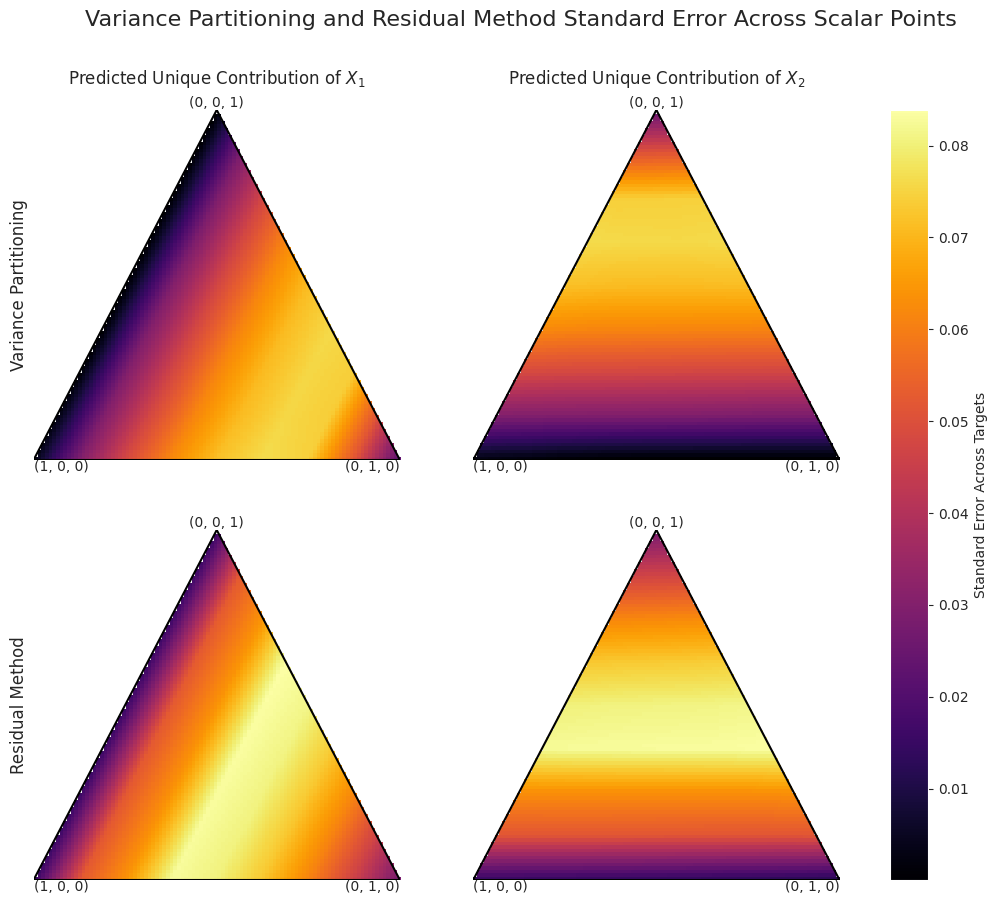

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

min_total = min(min(vp_x1_std_errors), min(vp_x2_std_errors), min(rm_x1_std_errors), min(rm_x2_std_errors))
max_total = max(max(vp_x1_std_errors), max(vp_x2_std_errors), max(rm_x1_std_errors), max(rm_x2_std_errors))

cmap = plt.get_cmap('inferno')
_, _, im_vp_x1 = plot_simplex(vp_x1_std_errors, ax=axs[0, 0], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_vp_x2 = plot_simplex(vp_x2_std_errors, ax=axs[0, 1], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_rm_x1 = plot_simplex(rm_x1_std_errors, ax=axs[1, 0], min_total=min_total, max_total=max_total, cmap=cmap)
_, _, im_rm_x2 = plot_simplex(rm_x2_std_errors, ax=axs[1, 1], min_total=min_total, max_total=max_total, cmap=cmap)

# add colorbar based on max values to figure
cbar = fig.colorbar(im_vp_x1, ax=axs, cmap='inferno')
cbar.set_label('Standard Error Across Targets')

fig.suptitle("Variance Partitioning and Residual Method Standard Error Across Scalar Points", fontsize=16)

# add column wise titles
axs[0, 0].set_title(r'Predicted Unique Contribution of $X_1$', y=1.05, fontsize=12)
axs[0, 1].set_title(r'Predicted Unique Contribution of $X_2$', y=1.05, fontsize=12)

# add row titles
axs[0, 0].set_ylabel(r'Variance Partitioning', fontsize=12)
axs[1, 0].set_ylabel(r'Residual Method', fontsize=12)